<a href="https://colab.research.google.com/github/chhavic4004/-gdi2019-/blob/main/random_forest_along_with_shap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Random Forest Regression Results:
RMSE: 0.0247
R^2 Score: 0.8112


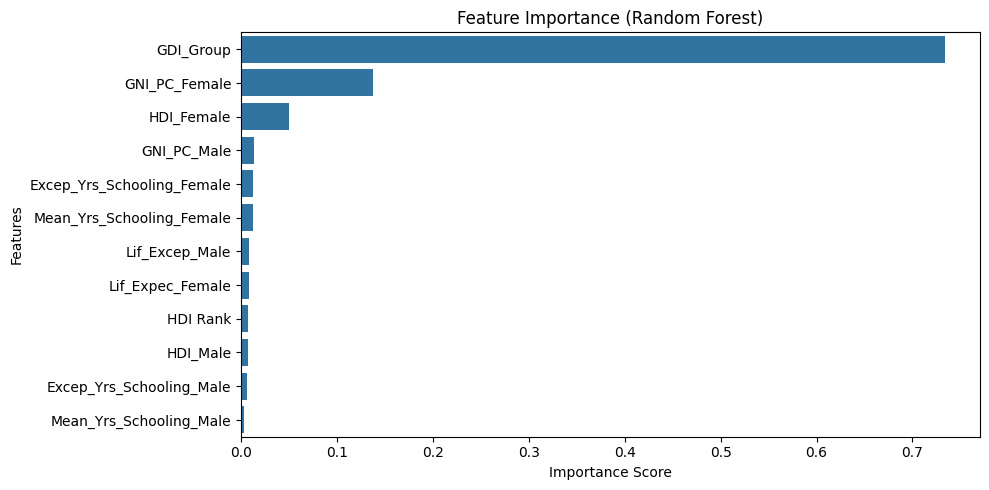

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# 1. Load the cleaned GDI data
df = pd.read_csv('GDI_cleaned.csv')

# 2. Encode categorical columns (if any)
categorical_cols = df.select_dtypes(include='object').columns.tolist()
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# 3. Select features and target
target_col = 'GDI_Value'
feature_cols = [col for col in df.columns if col != target_col and col != 'Country']

X = df[feature_cols]
y = df[target_col]

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Train the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 6. Predict
y_pred_rf = rf.predict(X_test)

# 7. Evaluation
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_rf)

print("Random Forest Regression Results:")
print(f"RMSE: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# 8. Feature Importance Visualization
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf.feature_importances_
feat_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=feat_importance, y=feat_importance.index)
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


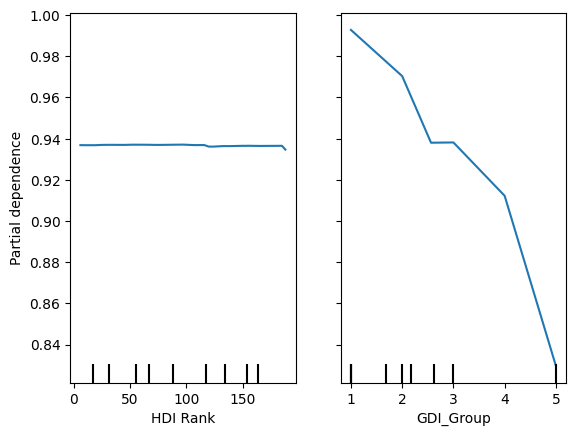

In [ ]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

features_to_plot = [0, 1]  # Replace with indices or names of your most important features
PartialDependenceDisplay.from_estimator(rf, X_test, features_to_plot)
plt.show()


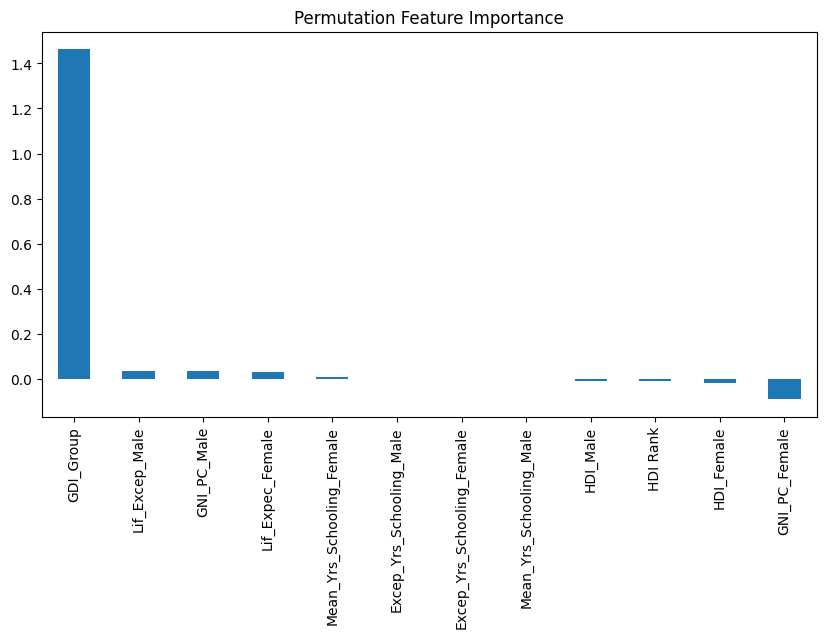

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
importances = pd.Series(result.importances_mean, index=X.columns)
importances.sort_values(ascending=False).plot.bar(figsize=(10,5), title='Permutation Feature Importance')
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best R^2 score:", grid_search.best_score_)


Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best R^2 score: 0.8375271959989192


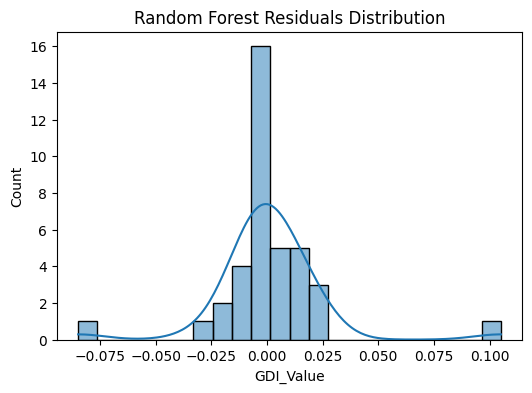

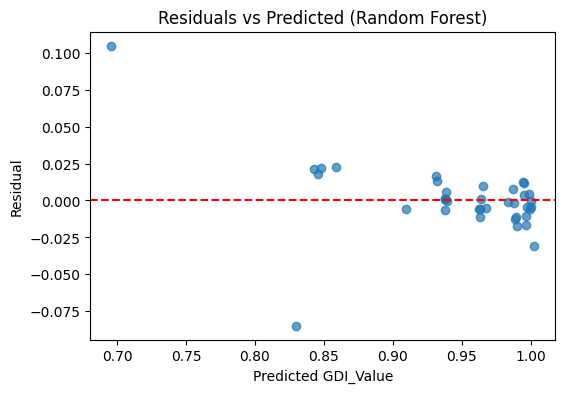

In [ ]:
residuals_rf = y_test - y_pred_rf
plt.figure(figsize=(6,4))
sns.histplot(residuals_rf, kde=True)
plt.title('Random Forest Residuals Distribution')
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(y_pred_rf, residuals_rf, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted GDI_Value')
plt.ylabel('Residual')
plt.title('Residuals vs Predicted (Random Forest)')
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print("Random Forest Cross-Validation R^2 Scores:", cv_scores)
print("Mean CV R^2 Score:", np.mean(cv_scores))


Random Forest Cross-Validation R^2 Scores: [-0.03949074  0.75569738  0.90203152  0.81479882  0.45064883]
Mean CV R^2 Score: 0.5767371610355212


/tmp/ipython-input-2-3239792358.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


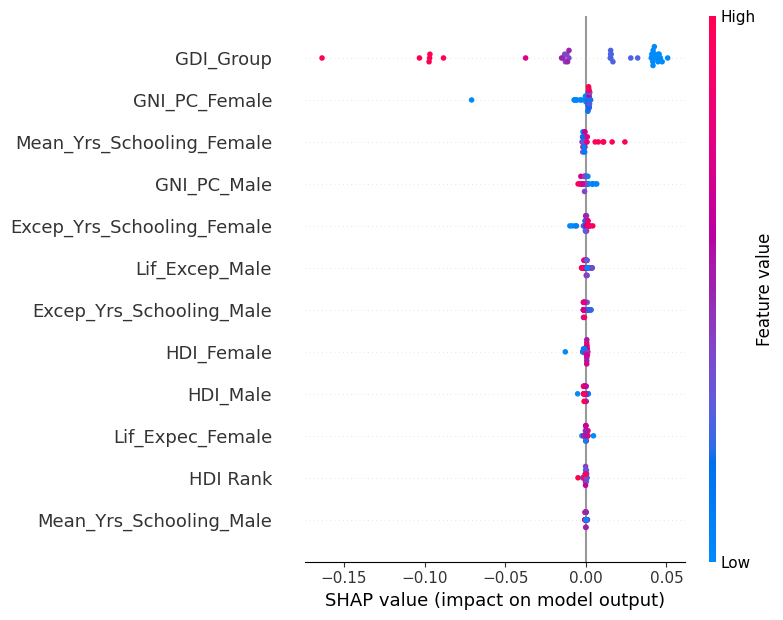

In [2]:
# 1. Install SHAP if not already installed
!pip install shap

# 2. Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt

# 3. Load the data (use your attached GDI.csv)
df = pd.read_csv('/content/GDI_cleaned.csv')

# 4. Clean header rows and handle missing values
df = df[df['Country'].notnull() & df['GDI_Value'].notnull() & (df['Country'] != 'Country')]

# 5. Convert numeric columns with commas to float
for col in ['GNI_PC_Female', 'GNI_PC_Male']:
    if col in df.columns:
        df[col] = df[col].replace({',': ''}, regex=True)
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 6. Convert other columns to numeric where possible (except 'Country')
for col in df.columns:
    if col not in ['Country']:
        df[col] = pd.to_numeric(df[col], errors='ignore')

# 7. Encode categorical columns (except 'Country')
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'Country']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# 8. Define features and target
target_col = 'GDI_Value'
feature_cols = [col for col in df.columns if col != target_col and col != 'Country']

X = df[feature_cols]
y = df[target_col]

# 9. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 10. Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 11. SHAP explainability
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_test)

# 12. SHAP summary plot (interactive in Colab)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# 13. SHAP force plot for a single prediction (first sample)
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values.values[0],
    X_test.iloc[0]
)
